1. **Import packages**

In [110]:
import pandas as pd
import scipy as sp
import sklearn as sk
import seaborn as sns
import matplotlib as mp
import statsmodels.api as sm
import pmdarima as pm
from datetime import datetime, timedelta
from scipy import stats
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb        #JZ
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from matplotlib.pyplot import plot
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

2. **Load data into pandas dataframe**

In [77]:
masterdf=pd.read_csv('data//CMaster2_HPS_CDC_CPS_Vaccinated.csv')

C:\ProgramData\Anaconda3\envs\py39tf\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [78]:
masterdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3131705 entries, 0 to 3131704
Data columns (total 25 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   YMFIPS                               object 
 1   YEAR                                 int64  
 2   MONTH                                object 
 3   FIPS                                 int64  
 4   STATE                                object 
 5   LOCATION                             object 
 6   TBIRTH_YEAR                          int64  
 7   EEDUC                                int64  
 8   THHLD_NUMPER                         int64  
 9   THHLD_NUMKID                         int64  
 10  THHLD_NUMADLT                        int64  
 11  WRKLOSS                              int64  
 12  KINDWORK                             int64  
 13  ANXIOUS                              int64  
 14  WORRY                                int64  
 15  DOWN                            

3. **Clean data**

* Convert year month fips field to datetime datatype

In [80]:
masterdf['YEARMONTH'] = pd.to_datetime(masterdf['YMFIPS'].str.slice(0, 6))
masterdf.head(5)[['YEARMONTH','YEAR','MONTH','WRKLOSS','KINDWORK','MORTLMTH','MORTCONF','INCOME','ANXIOUS','WORRY','DOWN']]
#masterdf.info()

,YEARMONTH,YEAR,MONTH,WRKLOSS,KINDWORK,MORTLMTH,MORTCONF,INCOME,ANXIOUS,WORRY,DOWN
0,2021-09-01,2021,SEP,2,-88,-88,-88,4,1,1,1
1,2021-09-01,2021,SEP,2,5,1,4,6,4,1,1
2,2021-09-01,2021,SEP,1,-88,1,3,1,1,1,3
3,2021-09-01,2021,SEP,1,2,-88,-88,-88,3,3,1
4,2021-09-01,2021,SEP,2,4,-88,-88,-88,4,4,4


* Understand how many records in work loss data element are null. Result is very few, so will just remove record with null wrkloss

In [81]:
df1=pd.DataFrame(masterdf['WRKLOSS'])
df1.groupby(['WRKLOSS']).size()

WRKLOSS
-99      19450
-88       7862
 1     1002257
 2     2102136
dtype: int64

* Given result, we should remove the records with -99/-88 values in WRKLOSS, ANXIOUS, WORRY, DOWN, INCOME

In [82]:
masterdf=masterdf[(masterdf['WRKLOSS'] != -99) & (masterdf['WRKLOSS'] !=-88) &
                  (masterdf['ANXIOUS'] != -99) & (masterdf['ANXIOUS'] !=-88) &
                  (masterdf['WORRY'] != -99) & (masterdf['WORRY'] !=-88) &
                  (masterdf['DOWN'] != -99) & (masterdf['DOWN'] !=-88) &
                  (masterdf['INCOME'] != -99) & (masterdf['INCOME'] !=-88)].reset_index(drop=True)

* Rename some fields, and drop some not needed for modeling

In [83]:
"""def awd_classify(awdnum:int=6)-> int :
    if awdnum <=4:
        awdclass=1
    elif awdnum <=7:
        awdclass=2
    elif awdnum <=10:
        awdclass=3
    else:
        awdclass=4
        
    return(awdclass)
"""

def awd_classify(awdnum:int=6)-> int :
    if awdnum <=7:
        awdclass=0
    else:
        awdclass=1       
    return(awdclass)


#masterdf=masterdf.rename(columns={"people_vaccinated": "VAXXED", "people_fully_vaccinated": "FULLYVAXXED"})
masterdf['ANXWORRYDWN']=masterdf.apply(lambda row: awd_classify(row['ANXIOUS']+row['WORRY']+row['DOWN']), axis=1)

masterdf=masterdf[['YEARMONTH','TBIRTH_YEAR','EEDUC','WRKLOSS','KINDWORK','MORTLMTH','MORTCONF',
                   'INCOME', 'REMPCT', 'CDCCOUNT', 
                   'people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred','ANXWORRYDWN']].reset_index(drop=True)
                
#masterdf=masterdf.drop(columns=['YMFIPS','YEAR','MONTH','FIPS','STATE','LOCATION','people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred'])

In [118]:
print(masterdf.info())
print(masterdf['ANXWORRYDWN'].value_counts())
masterdf.head(5)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960722 entries, 0 to 960721
Data columns (total 16 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   TBIRTH_YEAR                          960722 non-null  int64  
 1   EEDUC                                960722 non-null  int64  
 2   WRKLOSS                              960722 non-null  int64  
 3   MORTLMTH                             960722 non-null  int64  
 4   MORTCONF                             960722 non-null  int64  
 5   INCOME                               960722 non-null  int64  
 6   REMPCT                               960722 non-null  float64
 7   CDCCOUNT                             960722 non-null  float64
 8   people_vaccinated_per_hundred        960722 non-null  float64
 9   people_fully_vaccinated_per_hundred  960722 non-null  float64
 10  ANXWORRYDWN                          960722 non-null  int64  
 11  Work_Governme

,TBIRTH_YEAR,EEDUC,WRKLOSS,MORTLMTH,MORTCONF,INCOME,REMPCT,CDCCOUNT,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,ANXWORRYDWN,Work_Government,Work_Private,Work_NonProfit,Work_SelfEmp,Work_FamilyBiz
0,1973,4,2,1,4,6,0.032,44878.0,52.69,42.62,0,0,0,0,0,1
1,1989,7,1,1,3,5,0.048,7180.0,57.28,50.59,1,0,0,1,0,0
2,1969,6,2,1,4,6,0.048,7180.0,57.28,50.59,0,1,0,0,0,0
3,1952,6,2,1,4,3,0.043,58816.0,54.90,45.43,0,1,0,0,0,0
4,1968,3,2,1,3,5,0.056,75722.0,59.79,49.78,1,1,0,0,0,0


* Profile several fields

In [85]:
print('MORTLMTH values:', masterdf[(masterdf['MORTLMTH']!=-99) & (masterdf['MORTLMTH']!=-88)].shape[0])
print('MORTCONF values:', masterdf[(masterdf['MORTCONF']!=-99) & (masterdf['MORTCONF']!=-88)].shape[0])
print('KINDWORK values:', masterdf[(masterdf['KINDWORK']!=-99) & (masterdf['KINDWORK']!=-88)].shape[0])

masterdf=masterdf[(masterdf['MORTLMTH'] != -99) & (masterdf['MORTLMTH'] !=-88) &
                  (masterdf['MORTCONF'] != -99) & (masterdf['MORTCONF'] !=-88) &
                  (masterdf['KINDWORK'] != -99) & (masterdf['KINDWORK'] !=-88)].reset_index(drop=True)

# find total number of record with null vaxx values
print(masterdf['people_vaccinated_per_hundred'].isna().sum())
print(masterdf['people_fully_vaccinated_per_hundred'].isna().sum())
# backfill null vaxx values with 0
masterdf=masterdf.fillna(0).reset_index(drop=True)

#profile mental state values
print(masterdf['ANXWORRYDWN'].value_counts())

print(masterdf.info())

MORTLMTH values: 1472272
MORTCONF values: 1829379
KINDWORK values: 1464252
649519
649519
0    759582
1    201140
Name: ANXWORRYDWN, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960722 entries, 0 to 960721
Data columns (total 13 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   YEARMONTH                            960722 non-null  datetime64[ns]
 1   TBIRTH_YEAR                          960722 non-null  int64         
 2   EEDUC                                960722 non-null  int64         
 3   WRKLOSS                              960722 non-null  int64         
 4   KINDWORK                             960722 non-null  int64         
 5   MORTLMTH                             960722 non-null  int64         
 6   MORTCONF                             960722 non-null  int64         
 7   INCOME                               960722 non-null  int64         
 8  

* further edit the  MORTLMTH MORTCONF and KINDWORK data

In [86]:
print(masterdf['MORTLMTH'].value_counts())
print(masterdf['MORTCONF'].value_counts())
print(masterdf['KINDWORK'].value_counts())

1    893718
2     55842
3     11162
Name: MORTLMTH, dtype: int64
4    733097
3    138318
2     52637
1     23370
5     13300
Name: MORTCONF, dtype: int64
2    529748
1    176385
3    130348
4    106208
5     18033
Name: KINDWORK, dtype: int64


* convert MORTLMTH with values 2 and 3 to 0
* convert MORTCONF with values 5 to 1
* convert KINDWORK to categorical var

In [87]:
#replace values 2 and 3 with 0 (did not pay), existing 1 means paid
masterdf.loc[(masterdf['MORTLMTH'] == 2) | (masterdf['MORTLMTH'] == 3),'MORTLMTH']=0
print(masterdf['MORTLMTH'].value_counts())

#replace values 5 with 1 (did not pay)
masterdf.loc[(masterdf['MORTCONF'] == 5),'MORTCONF']=1
print(masterdf['MORTCONF'].value_counts())

#categorize/onehot the kind of work variable
KINDWORK_onehot = pd.get_dummies(masterdf['KINDWORK'])  
KINDWORK_onehot.rename(columns={1:'Work_Government',2:'Work_Private',3:'Work_NonProfit',4:'Work_SelfEmp',5:'Work_FamilyBiz'},inplace=True)
masterdf = pd.concat([masterdf,KINDWORK_onehot],axis=1)
print(masterdf.info())

1    893718
0     67004
Name: MORTLMTH, dtype: int64
4    733097
3    138318
2     52637
1     36670
Name: MORTCONF, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960722 entries, 0 to 960721
Data columns (total 18 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   YEARMONTH                            960722 non-null  datetime64[ns]
 1   TBIRTH_YEAR                          960722 non-null  int64         
 2   EEDUC                                960722 non-null  int64         
 3   WRKLOSS                              960722 non-null  int64         
 4   KINDWORK                             960722 non-null  int64         
 5   MORTLMTH                             960722 non-null  int64         
 6   MORTCONF                             960722 non-null  int64         
 7   INCOME                               960722 non-null  int64         
 8   REMPCT        

In [126]:
# drop columns not need for modeling
masterdf.drop(columns=['KINDWORK', 'YEARMONTH'],inplace=True)
masterdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960722 entries, 0 to 960721
Data columns (total 16 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   TBIRTH_YEAR                          960722 non-null  int64  
 1   EEDUC                                960722 non-null  int64  
 2   WRKLOSS                              960722 non-null  int64  
 3   MORTLMTH                             960722 non-null  int64  
 4   MORTCONF                             960722 non-null  int64  
 5   INCOME                               960722 non-null  int64  
 6   REMPCT                               960722 non-null  float64
 7   CDCCOUNT                             960722 non-null  float64
 8   people_vaccinated_per_hundred        960722 non-null  float64
 9   people_fully_vaccinated_per_hundred  960722 non-null  float64
 10  ANXWORRYDWN                          960722 non-null  int64  
 11  Work_Governme

* look at correlation

In [89]:
mdfcorr=masterdf.loc[:, masterdf.columns != 'ANXWORRYDWN'].corr()

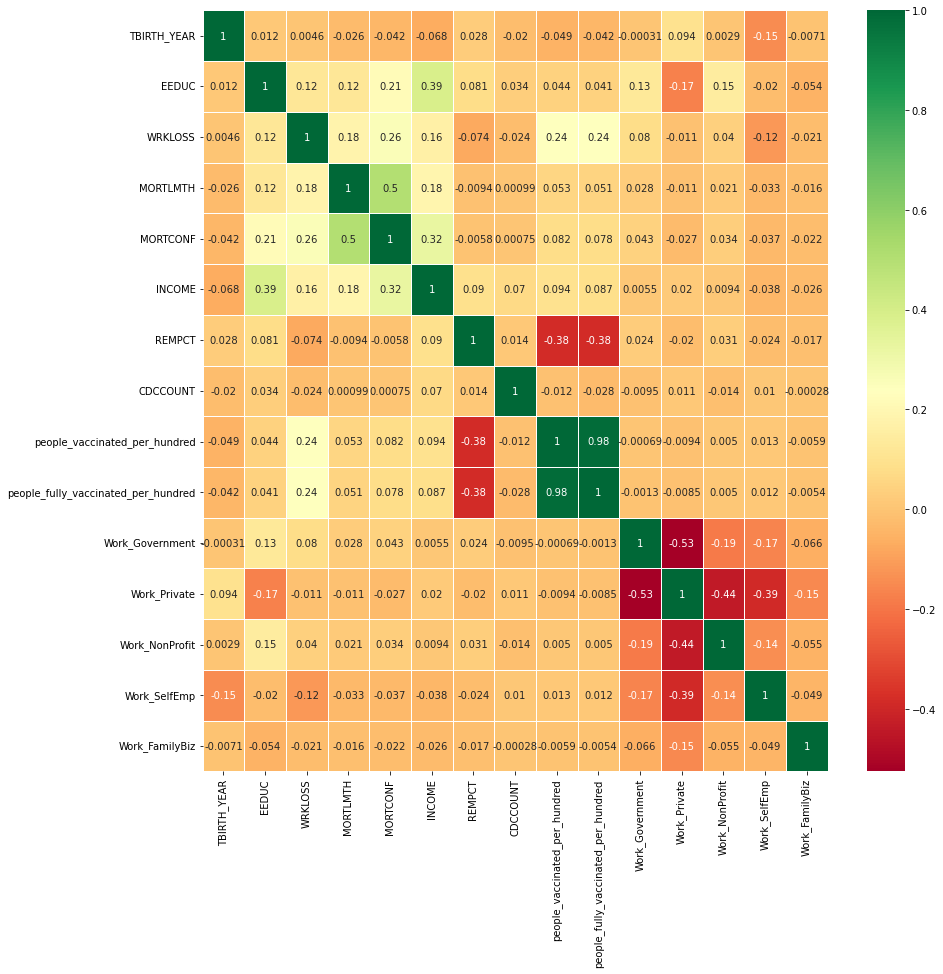

In [90]:
# heatmap plot
plt.figure(figsize=(14,14))
sns.heatmap(mdfcorr,cbar=True,linewidths=.5,yticklabels=True,xticklabels=True,annot=True,cmap="RdYlGn")
plt.show()

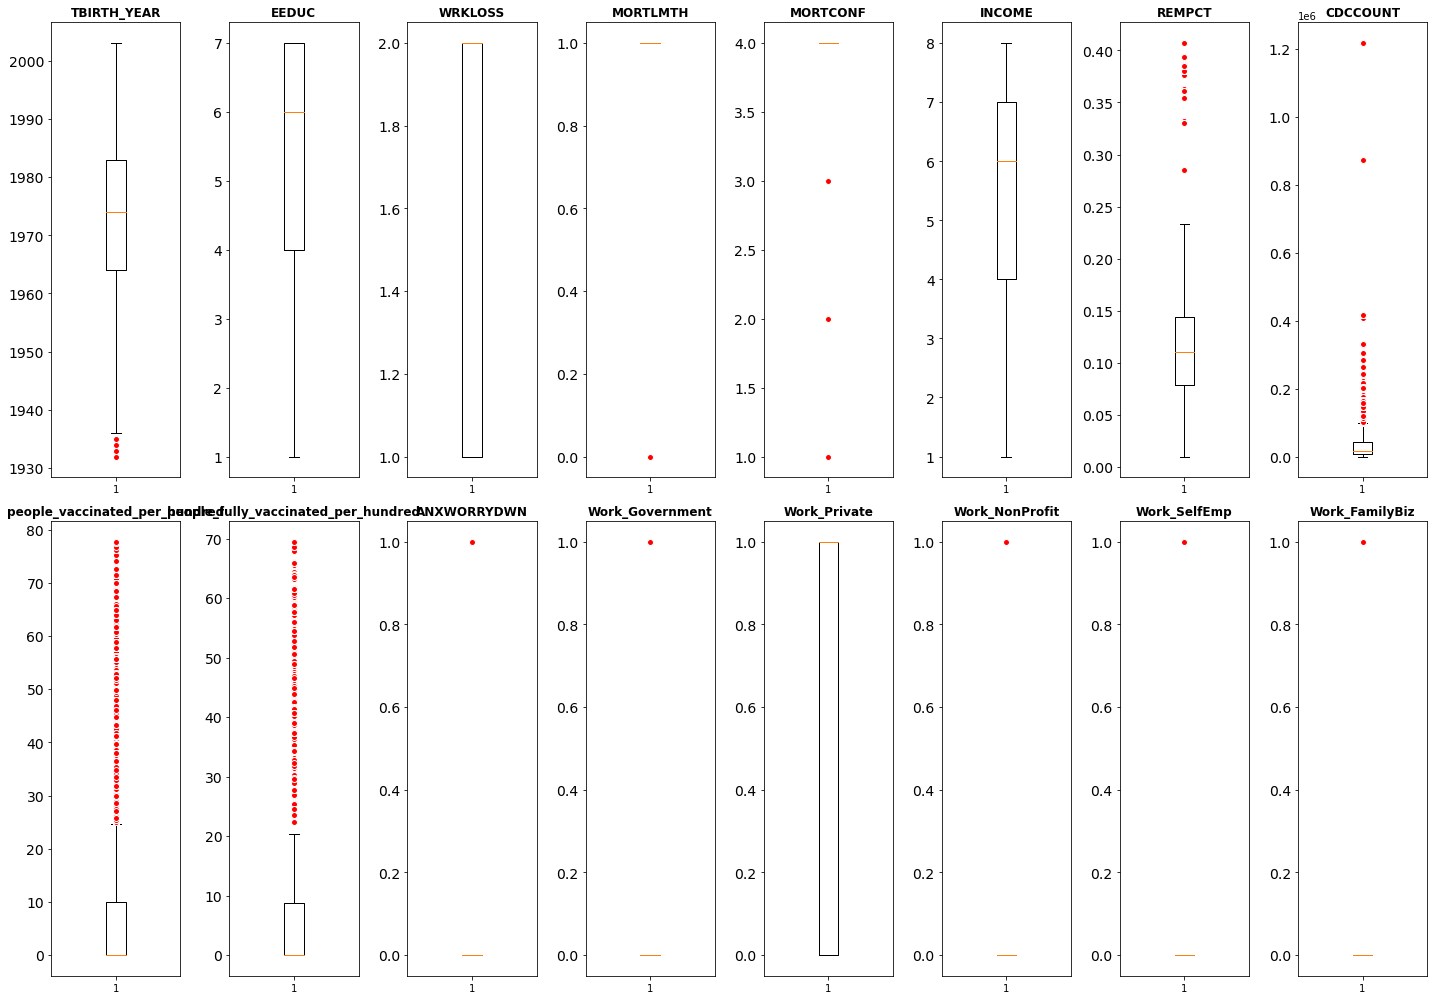

In [91]:
# box whisker plot  boxplot( seaborn and matplotlib)
# masterdf


#Creating subplot of each column with its own scale 
red_circle = dict(markerfacecolor='red' , marker='o', markeredgecolor='white') 
fig, axs = plt.subplots(2, round(len(masterdf.columns)/2), figsize=(20,14))
                        
for i, ax in enumerate(axs.flat):
    ax.boxplot(masterdf.iloc[:,i], flierprops=red_circle) 
    ax.set_title(masterdf.columns[i], fontsize=12, fontweight='bold') 
    ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()




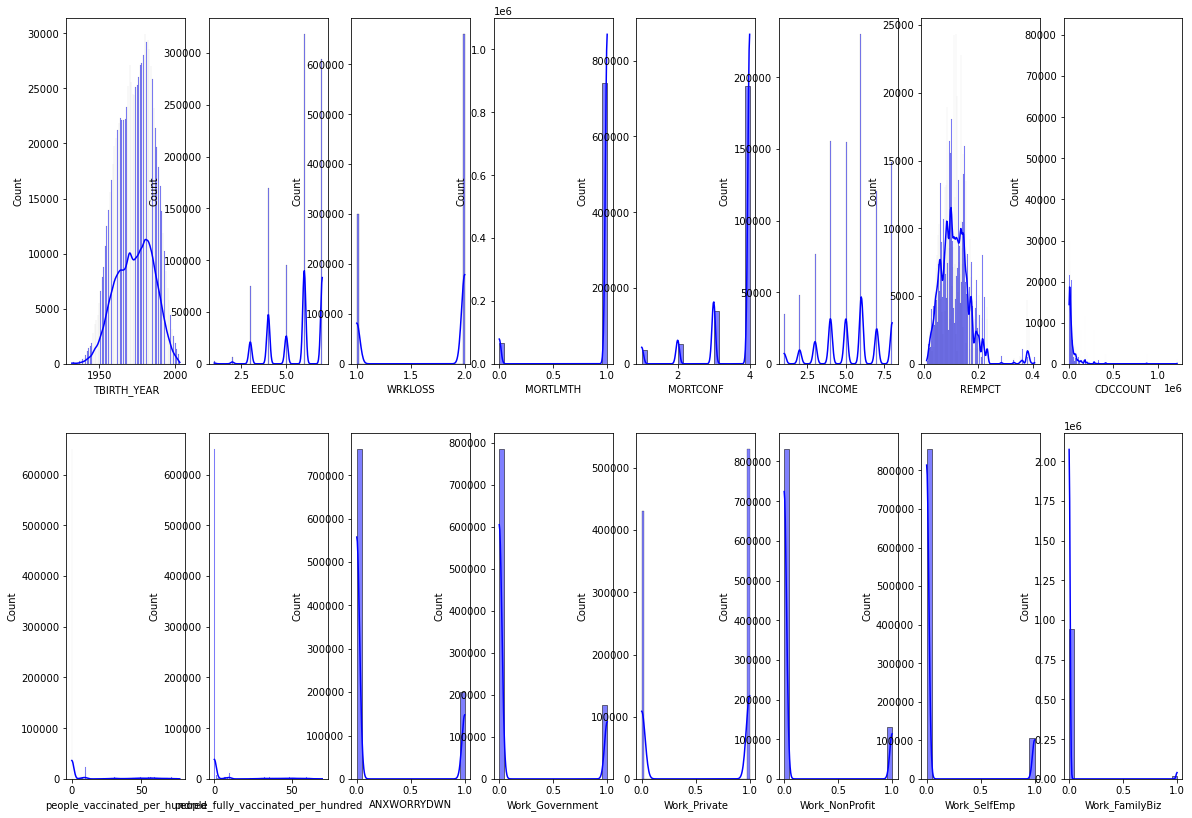

In [95]:
# distribution graph (kernel density estimate (kde) plot shape of dist)
fig, axs = plt.subplots(2, round(len(masterdf.columns)/2), figsize=(20,14))

for i, ax in enumerate(axs.flat):
    #sns.distplot(df[l[i]],kde=True)
    #scores = df.loc[(df['prog'] == prog)]['score']

    # note how I put 'ax' here
    sns.histplot(masterdf.iloc[:,i], kde=True, ax=ax, color='b')

    """# change all the axes into ax
    sigma = round(scores.std(), 3)
    mu = round(scores.mean(), 2)
    ax.set_xlim(1,7)
    ax.set_xticks(range(2,8))
    ax.set_xlabel('Score - Mean: {} (σ {})'.format(mu, sigma))
    ax.set_ylabel('Density')
    """

plt.show()

4. Performing modeling

**split data into train test**

In [127]:
#cutoffdate=pd.to_datetime('2021-07-01')
#print(cutoffdate, mindate_w_vax)
#earlyda = mdf_mlm.loc[(mdf_mlm['YEARMONTH']<= cutoffdate) & (mdf_mlm['YEARMONTH']>=mindate_w_vax)]

X_train, X_test, y_train, y_test = train_test_split(
    masterdf.loc[:, masterdf.columns[~masterdf.columns.isin(['ANXWORRYDWN'])]], 
    masterdf['ANXWORRYDWN'], 
    test_size=0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)

(720541, 15)
(240181, 15)


* oversampling for RF model

In [157]:
print(y_train.value_counts())
y_train_awd1idx=y_train[y_train == 1].index
y_train_awd1=y_train[y_train_awd1idx]
y_train_rf=pd.concat([y_train, y_train_awd1, y_train_awd1],ignore_index=True)
print(y_train_rf.value_counts(), len(y_train_rf))

X_train_awd1=X_train.loc[y_train_awd1idx]
X_train_rf=pd.concat([X_train, X_train_awd1, X_train_awd1], ignore_index=True)
print(len(X_train_rf))

0    569760
1    150781
Name: ANXWORRYDWN, dtype: int64
0    569760
1    452343
Name: ANXWORRYDWN, dtype: int64 1022103
1022103


* Deploy xgboost model

C:\ProgramData\Anaconda3\envs\py39tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:24:48] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.65617	validation_1-logloss:0.65631
[1]	validation_0-logloss:0.62622	validation_1-logloss:0.62636
[2]	validation_0-logloss:0.60137	validation_1-logloss:0.60171
[3]	validation_0-logloss:0.58086	validation_1-logloss:0.58133
[4]	validation_0-logloss:0.56382	validation_1-logloss:0.56436
[5]	validation_0-logloss:0.54956	validation_1-logloss:0.55019
[6]	validation_0-logloss:0.53766	validation_1-logloss:0.53832
[7]	validation_0-logloss:0.52760	validation_1-logloss:0.52838
[8]	validation_0-logloss:0.51918	validation_1-logloss:0.52001
[9]	validation_0-logloss:0.51208	validation_1-logloss:0.51300
[10]	validation_0-logloss:0.50609	validation_1-logloss:0.50710
[11]	validation_0-logloss:0.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

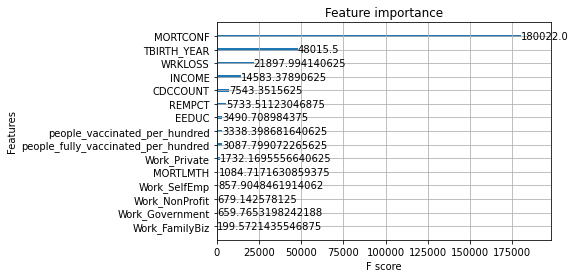

In [97]:
# Set up xg model, fit the model
mdf_xg =XGBClassifier(n_estimators=60,learning_rate=0.1) #optimize?
mdf_xg.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], early_stopping_rounds=10, verbose=True)
print(mdf_xg.score(X_test, y_test))
#print(mdf_mlm_xg.evals_result())
feature_importance=mdf_xg.feature_importances_
feature_imp_pd=pd.DataFrame(feature_importance)
print(feature_imp_pd.sort_values(0, ascending=False))

#importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
xgg=mdf_xg.get_booster().get_score(importance_type='total_gain')
print(xgg)

xgb.plot_importance(mdf_xg,importance_type='total_gain') # jz

In [98]:
# run prediction and evaluate metrics
mdf_xg_p = mdf_xg.predict(X_test)
print(type(mdf_xg_p))

print('XG Accuracy score = ', metrics.accuracy_score(mdf_xg_p, y_test))
print('XG MAE = ', metrics.mean_absolute_error(mdf_xg_p, y_test))
print('XG RMSE = ', metrics.mean_squared_error(mdf_xg_p, y_test, squared=False))

<class 'numpy.ndarray'>
XG Accuracy score =  0.7922275284056607
XG MAE =  0.20777247159433926
XG RMSE =  0.455820657270312


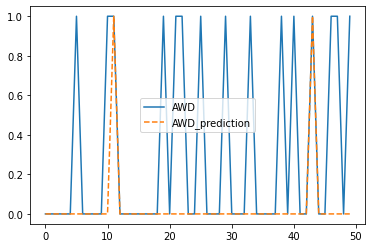

In [99]:
yt=pd.DataFrame(y_test.to_list())
#print(yt[0:5])

ypredict=pd.DataFrame(mdf_xg_p)
#print(ypredict[0:5])
plt.plot(yt[0:50], label = "AWD", linestyle="-")
plt.plot(ypredict[0:50], label = "AWD_prediction", linestyle="--")
plt.legend()
plt.show()



* Deploying random forest model

In [161]:
# Set up RF model, fit the model
mdf_rf = RandomForestClassifier(n_estimators=200,min_samples_leaf=30,bootstrap=True, oob_score=True, n_jobs=-1)
mdf_rf.fit(X_train, y_train)

feature_importance=mdf_rf.feature_importances_
feature_imp_pd=pd.DataFrame(feature_importance)
#print(feature_imp_pd.sort_values(0, ascending=False))

C:\ProgramData\Anaconda3\envs\py39tf\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [162]:
feat_map= zip(X_train.columns, feature_imp_pd[0].to_list())
feat_map=pd.DataFrame(feat_map)
feat_map.columns=(['FEATURE','IMPORTANCE'])
print(feat_map.sort_values('IMPORTANCE', ascending=False))

print('score', mdf_rf.score(X_train,y_train))

                                FEATURE  IMPORTANCE
4                              MORTCONF    0.331536
0                           TBIRTH_YEAR    0.160306
7                              CDCCOUNT    0.095136
6                                REMPCT    0.086523
5                                INCOME    0.081649
2                               WRKLOSS    0.080980
3                              MORTLMTH    0.042577
8         people_vaccinated_per_hundred    0.033711
9   people_fully_vaccinated_per_hundred    0.032405
1                                 EEDUC    0.031785
11                         Work_Private    0.007417
10                      Work_Government    0.005330
13                         Work_SelfEmp    0.004965
12                       Work_NonProfit    0.004608
14                       Work_FamilyBiz    0.001072
score 0.7977616818473897


In [163]:
# run prediction and evaluate metrics
mdf_rf_p = mdf_rf.predict(X_test)
#print(type(mdf_rf_p))

print('RF Accuracy score= ', metrics.accuracy_score(mdf_rf_p, y_test))
print('RF MAE = ', metrics.mean_absolute_error(mdf_rf_p, y_test))
print('RF RMSE = ', metrics.mean_squared_error(mdf_rf_p, y_test, squared=False))
print('RF F1_score=', metrics.f1_score(mdf_rf_p, y_test))

RF Accuracy score=  0.7923024718857862
RF MAE =  0.20769752811421385
RF RMSE =  0.45573844265566826
RF F1_score= 0.08409070044983018


* Deploy NaiveBayes 

In [103]:
clf = GaussianNB()
clf.fit(X_train, y_train)
clf.score(X_test,y_test)


0.7876268314312955

* Deploy MLPclassifier

In [104]:
clf = MLPClassifier(hidden_layer_sizes=(15,10,8,6,4), random_state=1, max_iter=200)
clf.fit(X_train, y_train)
print(clf.predict_proba(X_test[:1]))
clf.score(X_test, y_test)

[[0.79130528 0.20869472]]


0.7903289602424838

In [105]:
mdf_mlp_p=clf.predict(X_test)
print('MLP Accuracy score= ', metrics.accuracy_score(mdf_mlp_p, y_test))
print('MLP MAE = ', metrics.mean_absolute_error(mdf_mlp_p, y_test))

MLP Accuracy score=  0.7903289602424838
MLP MAE =  0.20967103975751622


* Deploy logistic regression

In [106]:
clf = LogisticRegression(random_state=1, max_iter=200)
#clf = LogisticRegression(random_state=1, penalty='elasticnet', solver='saga',l1_ratio=0.7, max_iter=200)
clf.fit(X_train, y_train)

print(clf.predict_proba(X_test[:1]))
print(clf.score(X_test, y_test))

mdf_lr_p=clf.predict(X_test)
print('LR Accuracy score= ', metrics.accuracy_score(mdf_lr_p, y_test))
print('LR MAE = ', metrics.mean_absolute_error(mdf_lr_p, y_test))


[[0.83210161 0.16789839]]
0.7903289602424838
LR Accuracy score=  0.7903289602424838
LR MAE =  0.20967103975751622


**This is very interesting**

TBIRTH_YEAR 	 -0.0006313076660595344
EEDUC 	 -0.00024160786854805473
WRKLOSS 	 -0.0002007676808385554
MORTLMTH 	 -9.815274879914051e-05
MORTCONF 	 -0.000536150588428527
INCOME 	 -0.000850696539943484
REMPCT 	 2.8383780603182996e-06
CDCCOUNT 	 3.5945940608413846e-07
people_vaccinated_per_hundred 	 -0.004498009538856443
people_fully_vaccinated_per_hundred 	 -0.0036421817949964554
Work_Government 	 -7.213778207674463e-06
Work_Private 	 -8.146724066756332e-07
Work_NonProfit 	 6.258380978458151e-06
Work_SelfEmp 	 -4.6563024262833765e-06
Work_FamilyBiz 	 3.7128046872091367e-06


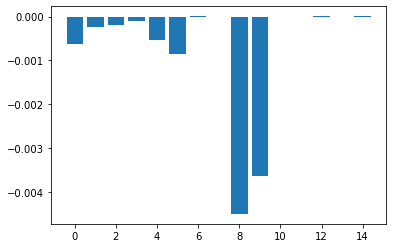

In [107]:
feat_imp = clf.coef_[0]
# summarize feature importance
for i,v in enumerate(feat_imp):
    #print('%s, feature_score: %.5f' % (X_test.columns[i],v))
    print(X_test.columns[i],'\t',v)
# plot feature importance
plt.bar([x for x in range(len(feat_imp))], feat_imp)
plt.show()

* k nearest neighbors classifier

In [111]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train)
mdf_knn_p=clf.predict(X_test)

In [115]:
#print(clf.score(X_test, y_test))
print('LR Accuracy score= ', metrics.accuracy_score(mdf_knn_p, y_test))
print('LR MAE = ', metrics.mean_absolute_error(mdf_knn_p, y_test))

LR Accuracy score=  0.7866234215029498
LR MAE =  0.21337657849705013
